In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
%matplotlib inline

#주문번호 , 제품코드 , 주문량 ,주문일자 제품단가 주문고객번호 주문고객국가등 
retail_data = pd.read_excel("/Users/hyunwoo/Downloads/Online Retail.xlsx")
retail_data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
np.round(retail_data.isnull().sum()/len(retail_data),4) # 25퍼센트정도 고객ID값이 null이다

InvoiceNo      0.0000
StockCode      0.0000
Description    0.0027
Quantity       0.0000
InvoiceDate    0.0000
UnitPrice      0.0000
CustomerID     0.2493
Country        0.0000
dtype: float64

In [12]:
retail_data.describe()
#Quantity , UnitPrice 가 음수인건 말이 안된다.

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [13]:
retail_data.dropna(inplace=True)
retail_data = retail_data[retail_data['Quantity']>0]
retail_data = retail_data[retail_data['UnitPrice']>0]
retail_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [16]:
retail_data['CustomerID'] = retail_data['CustomerID'].astype(int)
retail_data['CustomerID'].value_counts().head(5)

17841    7847
14911    5675
14096    5111
12748    4595
14606    2700
Name: CustomerID, dtype: int64

In [18]:
retail_data['Revenue'] = retail_data['Quantity']*retail_data['UnitPrice']
retail_data['Country']

0         United Kingdom
1         United Kingdom
2         United Kingdom
3         United Kingdom
4         United Kingdom
               ...      
541904            France
541905            France
541906            France
541907            France
541908            France
Name: Country, Length: 397884, dtype: object

In [20]:
retail_data.reset_index(inplace=True)
retail_data.drop(columns={"index"},inplace= True)

In [32]:
aggregations = {"InvoiceDate":"max","InvoiceNo":"count","Revenue":"sum"}
customer = retail_data.groupby("CustomerID").agg(aggregations)
customer.rename(columns = {"InvoiceDate": "RecentPurchase","InvoiceNo":"PurchaseFrequency","Revenue":"TotalPurchase"},inplace= True)

In [33]:
customer.reset_index(inplace=True)

(array([4.303e+03, 1.800e+01, 9.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([3.75000000e+00, 2.80239770e+04, 5.60442040e+04, 8.40644310e+04,
        1.12084658e+05, 1.40104885e+05, 1.68125112e+05, 1.96145339e+05,
        2.24165566e+05, 2.52185793e+05, 2.80206020e+05]),
 <BarContainer object of 10 artists>)

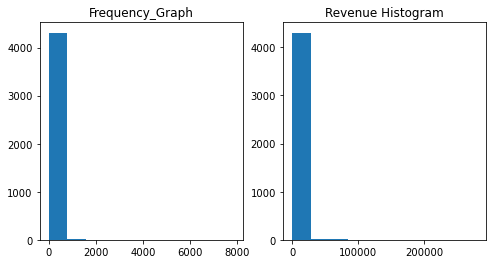

In [38]:
import datetime as dt
fig, (ax1,ax2) = plt.subplots(figsize=(8,4),nrows=1,ncols=2)
ax1.set_title("Frequency_Graph")
ax1.hist(customer['PurchaseFrequency'])

ax2.set_title("Revenue Histogram")
ax2.hist(customer["TotalPurchase"])

In [39]:
customer['RecentPurchase'] = dt.datetime(2011,12,10) - customer['RecentPurchase']
customer['RecentPurchase'] = customer["RecentPurchase"].apply(lambda x : x.days+1)


In [41]:
customer_features = customer[customer.columns[1:]]

In [44]:
customer_features

,RecentPurchase,PurchaseFrequency,TotalPurchase
0,326,1,77183.60
1,3,182,4310.00
2,76,31,1797.24
3,19,73,1757.55
4,311,17,334.40
...,...,...,...
4333,278,10,180.60
4334,181,7,80.82
4335,8,12,178.05
4336,4,756,2094.88


In [51]:
#Standard Scaler 변환후 클러스터링 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score

std_scaler = StandardScaler()
std_scaler.fit(customer_features)
std_customer_features = std_scaler.transform(customer_features)

kmeans = KMeans(n_clusters =3)
labels = kmeans.fit_predict(std_customer_features)
customer["label"] = labels


In [52]:
customer

,CustomerID,RecentPurchase,PurchaseFrequency,TotalPurchase,label
0,12346,326,1,77183.60,1
1,12347,3,182,4310.00,0
2,12348,76,31,1797.24,0
3,12349,19,73,1757.55,0
4,12350,311,17,334.40,1
...,...,...,...,...,...
4333,18280,278,10,180.60,1
4334,18281,181,7,80.82,1
4335,18282,8,12,178.05,0
4336,18283,4,756,2094.88,0


In [53]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

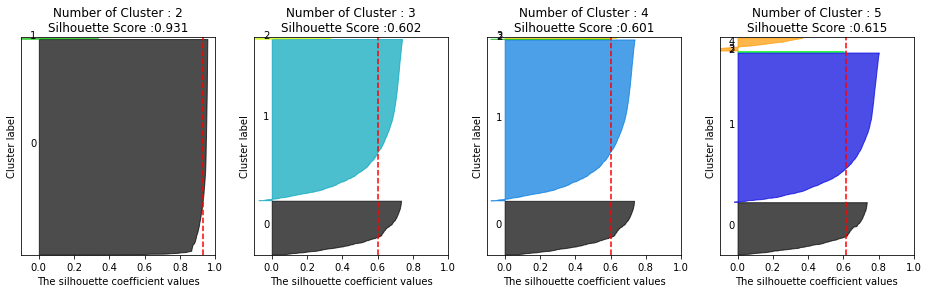

In [54]:
visualize_silhouette([2,3,4,5],std_customer_features)

In [ ]:
ㅌㅌ5